In [1]:
from data_preparer import DataPreparer
from allocator import Allocator
import pickle
from tqdm import tqdm
from helpers.graph_consistency import *
import json

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
preparer = DataPreparer(
        data_path="cold_data/description_vectors.pkl",
        textual_path="cold_data/textual_information.csv",
        stock2idPath="cold_data/stock2id.csv",
        stockDataPath="cold_data/stock_data.csv"
)
allocator = Allocator()
trade_start_date = "2023-05-26"

In [60]:
ts_weights = np.arange(0, 1.05, 0.05)
tx_weights = 1 - ts_weights
thresholds = np.arange(0.15, 1, 0.05)
calculated_consistencies = {}

metric_list = ["distCorr", "dtw", "pearson", ""]
for metric in metric_list:
    calculated_consistencies[metric] = {}
    if metric != "":
        with open(f"calculated_data/historical_ts_sim_{metric}.pkl", "rb") as f:
            ts_sim = pickle.load(f)      
    else:
        metric = "euclidean"
        with open(f"calculated_data/historical_ts_sim.pkl", "rb") as f:
            ts_sim = pickle.load(f)

    filtered_sims = {}
    
    for k in list(ts_sim.keys())[:2]:
        filtered_sims[k] = ts_sim[k]
    preparer.ts_similarities = filtered_sims
    
    for threshold in thresholds:
        calculated_consistencies[metric][threshold] = {}
        print(metric, threshold)
        
        for w_id in tqdm(range(len(ts_weights))):
            ts_w, tx_w = ts_weights[w_id], tx_weights[w_id]
            preparer.prepare_snapshots(weight_combination={"ts":ts_w, "tx":tx_w}, threshold=threshold)
            train_shots = preparer.snapshots
            snaphot_count = len(train_shots)
            
            snapshot_consistencies = []
            for snapshot_id in range(1):
                temp_list = []
                for i in range(3):
                    c = graph_consistency(
                    g=train_shots[snapshot_id], stock_list=preparer.stock2id, p_h=0.2 
                    )
                    if np.isnan(c):
                        c = 0
                        
                    temp_list.append(c)
                    
                snapshot_consistencies.append(np.mean(temp_list))
            calculated_consistencies[metric][threshold][ts_w] = snapshot_consistencies
            
            with open("consistency.json", "w") as file:
                json.dump(calculated_consistencies, file, indent=4)

 95%|█████████▌| 20/21 [02:47<00:08,  8.36s/it]


KeyboardInterrupt: 

In [ ]:
data = calculated_consistencies["distCorr"]
l = []
for row in data.keys():
    row_thresholds = data[row].keys() 
    
    for th in row_thresholds:
        l.append(np.mean(data[row][th]))
        print()
        print(round(row, 3), round(th, 3), np.mean(data[row][th]))

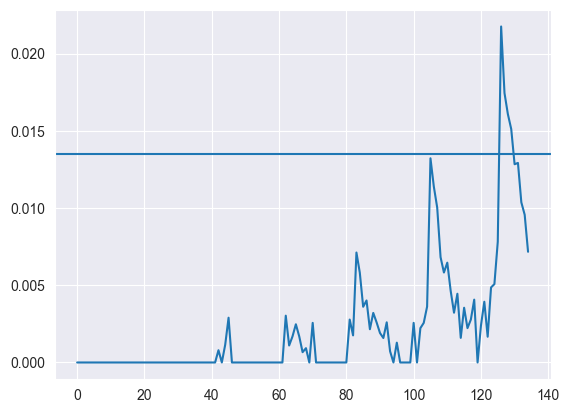

In [54]:
from matplotlib import pyplot as plt

plt.plot(l)
plt.axhline(0.0135)

In [189]:
with open(f"calculated_data/historical_ts_sim.pkl", "rb") as f:
    ts_sim = pickle.load(f)   

filtered_sims = {}
for k in list(ts_sim.keys())[:3]:
    filtered_sims[k] = ts_sim[k]
preparer.ts_similarities = filtered_sims            

selected_combinations = [] # ts, tx, threshold
thresholds = np.arange(0.05, 1.0, 0.05)
ts_weights = np.arange(0.05, 1.0, 0.05)

for th in tqdm(thresholds):
    for ts_w in ts_weights:
        tx_w = 1.0-ts_w
        
        preparer.prepare_snapshots(weight_combination={"ts":ts_w, "tx":tx_w}, threshold=th)
        density_list = [preparer.snapshots[0].density(), preparer.snapshots[1].density(), preparer.snapshots[2].density()]
        transitivity_list = [preparer.snapshots[0].transitivity_undirected(), preparer.snapshots[1].transitivity_undirected(), preparer.snapshots[2].transitivity_undirected()]
        degree_list = [preparer.snapshots[0].degree_distribution().mean, preparer.snapshots[1].degree_distribution().mean, preparer.snapshots[2].degree_distribution().mean]
        
        avg_density = np.mean(density_list)
        avg_transitivity = np.mean(transitivity_list)
        avg_dengree = np.mean(degree_list)

        if avg_transitivity >= 0.3 and avg_density <= 0.04 and avg_density >= 0.02:
            selected_combinations.append([ts_w, tx_w, th])

100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


In [116]:
np.save('onlyTS_dtw_combinationsv3.npy', selected_combinations)

In [117]:
ph = 0.25
combinations = np.load("onlyTS_dtw_combinationsv3.npy")
combination_consistencies = {}

for i in tqdm(range(len(combinations))):
    ts, tx, th = combinations[i]
    
    if round(th, 3) not in list(combination_consistencies.keys()):
        combination_consistencies[round(th, 3)] = {}
    if round(ts, 3) not in list(combination_consistencies[round(th, 3)].keys()):
        combination_consistencies[round(th, 3)][round(ts, 3)] = []
    
    preparer.prepare_snapshots(weight_combination={"ts":ts, "tx":tx}, threshold=th)
    for attempt in range(5):
        c1 = graph_consistency(g=preparer.snapshots[0], stock_list=preparer.stock2id, p_h=ph)
        c2 = graph_consistency(g=preparer.snapshots[1], stock_list=preparer.stock2id, p_h=ph)
        c3 = graph_consistency(g=preparer.snapshots[2], stock_list=preparer.stock2id, p_h=ph)

        combination_consistencies[round(th, 3)][round(ts, 3)].append(np.mean([c1, c2, c3]))

100%|██████████| 1/1 [00:11<00:00, 11.05s/it]


In [118]:
with open(f"combinations/selected_combinations_dtw_onlyTS.json", "w") as file:
    json.dump(combination_consistencies, file, indent=4)

In [121]:
with open("combinations/selected_combinations_pearson_onlyTS.json", "r") as file:
    combination_consistencies = json.load(file)

In [122]:
best_ = -np.inf
for th_key in list(combination_consistencies.keys()):
    for w_key in list(combination_consistencies[th_key].keys()):
        if (np.mean(combination_consistencies[th_key][w_key])) > best_:
            best_ = np.mean(combination_consistencies[th_key][w_key])
            print("threshold:", th_key, "ts weight:", w_key, round(best_, 4))

threshold: 0.15 ts weight: 1.0 0.0065


In [202]:
preparer.prepare_snapshots(weight_combination={"ts":0.6, "tx":0.4}, threshold=0.3)
print(graph_consistency(g=preparer.snapshots[0], stock_list=preparer.stock2id, p_h=0.25))
len(preparer.snapshots[0].es), preparer.snapshots[0].density(), preparer.snapshots[0].degree_distribution().mean

In [57]:
trials = []
thresholds = []
weights = []
metrics = []
consistencies = []
metric_list = ["euclidean", "pearson", "dtw", "distCorr"]

consistency_df = pd.DataFrame(columns=["threshold", "tsWeight", "metric", "trial1", "trial2", "trial3", "trial4", "trial5", "average"])

for metric in metric_list:
    with open(f"combinations/selected_combinations_{metric}.json", "r") as file:
        combination_consistencies = json.load(file)
    
    threshold_list = combination_consistencies.keys()
    for threshold in threshold_list:
        ts_weight_list = combination_consistencies[threshold].keys()
        
        for ts_weight in ts_weight_list:
            consistency_list = combination_consistencies[threshold][ts_weight]
            
            weights.append(ts_weight)
            thresholds.append(threshold)
            metrics.append(metric)
            consistencies.append(consistency_list)

In [78]:
consistency_df["threshold"] = thresholds
consistency_df["tsWeight"] = weights
consistency_df["metric"] = metrics

consistency_df["trial1"] = np.array(consistencies)[:, 0]
consistency_df["trial2"] = np.array(consistencies)[:, 1]
consistency_df["trial3"] = np.array(consistencies)[:, 2]
consistency_df["trial4"] = np.array(consistencies)[:, 3]
consistency_df["trial5"] = np.array(consistencies)[:, 4]
consistency_df["average"] = consistency_df[["trial1", "trial2", "trial3", "trial4", "trial5"]].mean(axis=1)
consistency_df["std"] = consistency_df[["trial1", "trial2", "trial3", "trial4", "trial5"]].std(axis=1)

In [87]:
consistency_df.to_csv("consistency_combinations.csv", index=False)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

consistency_df = pd.read_csv("consistency_combinations.csv")

In [3]:
dst = consistency_df[consistency_df.metric=="distCorr"].sort_values(by="tsWeight", ascending=True)[["threshold", "tsWeight", "metric", "average"]]
dtw = consistency_df[consistency_df.metric=="dtw"].sort_values(by="tsWeight", ascending=True)[["threshold", "tsWeight", "metric", "average"]]
pear = consistency_df[consistency_df.metric=="pearson"].sort_values(by="tsWeight", ascending=True)[["threshold", "tsWeight", "metric", "average"]]
euc = consistency_df[consistency_df.metric=="euclidean"].sort_values(by="tsWeight", ascending=True)[["threshold", "tsWeight", "metric", "average"]]

In [4]:
def add_border(ax, color='black', width=1):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(width)

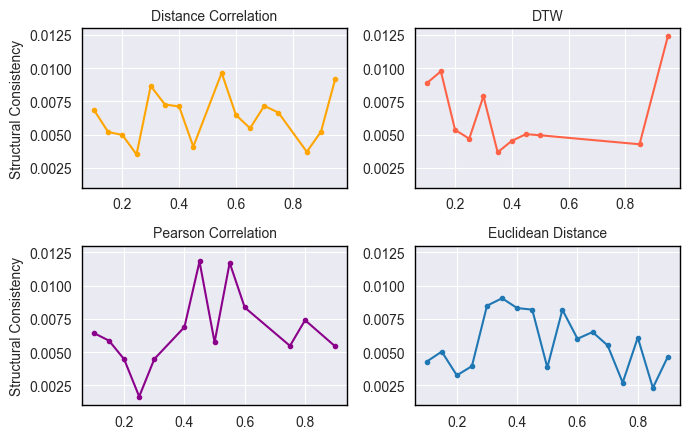

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(7, 4.5)) 
(ax1, ax2), (ax3, ax4) = ax

ax1.plot(
     dst.tsWeight, dst.average, marker=".", label="Consistency", color="orange"
)
ax1.set_title("Distance Correlation", fontsize=10)
ax1.set_ylim(0.0010, 0.013)
add_border(ax1)

ax2.plot(
     dtw.tsWeight, dtw.average, marker=".", label="Consistency", color="tomato"
)
ax2.set_title("DTW", fontsize=10)
ax2.set_ylim(0.0010, 0.013) 
add_border(ax2)

ax3.plot(
     pear.tsWeight, pear.average, marker=".", label="Consistency", color="darkmagenta"
)
ax3.set_title("Pearson Correlation", fontsize=10)
ax3.set_ylim(0.0010, 0.013) 
add_border(ax3)

ax4.plot(
     euc.tsWeight, euc.average, marker=".", label="Consistency"
)
ax4.set_title("Euclidean Distance", fontsize=10)
ax4.set_ylim(0.0010, 0.013) 
add_border(ax4)

ax1.set_ylabel("Structural Consistency")
ax3.set_ylabel("Structural Consistency")
plt.tight_layout()

plt.savefig("structural_consistency.png",  dpi=300, bbox_inches='tight')